SVR Round-by-Round Model with Professional Hyperparameter Tuning

1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from joblib import dump

from scipy.stats import loguniform, uniform

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 21-22.csv"
df = pd.read_csv(file_path, usecols=usecols)

# Assign match index and round (10 matches per round)
df['MatchIndex'] = df.index + 1
df['Round'] = np.ceil(df['MatchIndex'] / 10).astype(int)

# Convert kick‐off time to hour and bucket into Morning/Afternoon/Evening
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# %% 
# 3.1 Targets
df['Outcome']  = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5']  = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# %% 
# 3.2 Implied probabilities from odds
for side in ['H','D','A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5','ImpUnder2.5']] = (
    df[['ImpOver2.5','ImpUnder2.5']]
      .div(df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1), axis=0)
)

# %% 
# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# %% 
# 3.4 Rolling 3-match form
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# %% 
# 3.5 Win/Loss streaks
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# %% 
# 3.6 Interaction
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# %% 
# 3.7 Referee home-bias
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins','RefMatches'], inplace=True)

# %% 
# 3.8 Head-to-head last result
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key  = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# %% 
# 3.9 Rolling averages of match stats
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# %% 
# 3.10 Previous-round table positions
df['HomePts'] = np.where(df['FTR']=='H', 3, np.where(df['FTR']=='D', 1, 0))
df['AwayPts'] = np.where(df['FTR']=='A', 3, np.where(df['FTR']=='D', 1, 0))

pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],   df['AwayPts']])
})
round_pts = (
    pts
    .groupby(['Team','Round'], as_index=False)['Pts']
    .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts
    .groupby('Round')['CumPts']
    .rank(method='min', ascending=False)
)

prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev, left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(
    prev, left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

# 3.11 Final clean-up (types & safe replacements)
# cast categoricals to string (encoder in Section 4 expects strings)
for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay']:
    if c in df.columns:
        df[c] = df[c].astype(str)

# replace inf/-inf with NaN (imputers in Section 4 handle NaNs safely)
import numpy as np
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# ensure FormDiff feature exists (home form − away form)
if 'FormDiff' not in df.columns and {'HomeForm3','AwayForm3'}.issubset(df.columns):
    df['FormDiff'] = df['HomeForm3'] - df['AwayForm3']


4. Pipeline Specification & Hyperparameter Distributions (SVR)

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
import numpy as np

# reuse defaults if not defined earlier
if 'home_stats' not in globals():
    home_stats = ['HS','HST','HF','HC','HY','HR']
if 'away_stats' not in globals():
    away_stats = ['AS','AST','AF','AC','AY','AR']

# 4.1 Feature lists
cat_feats = ['HomeTeam','AwayTeam','Referee','TimeOfDay']

num_feats = [
    'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5',
    'OddsSpread','Spread×Form','FormDiff','RefBias','H2H_Last',
    'HomePosPrev','AwayPosPrev'
] + [f'Home_{s}_3' for s in home_stats] + [f'Away_{s}_3' for s in away_stats]

# 4.2 Guard: keep only existing columns
_existing = set(df.columns)
_missing = [c for c in cat_feats + num_feats if c not in _existing]
if _missing:
    print("Note: dropping missing features:", _missing)
cat_feats = [c for c in cat_feats if c in _existing]
num_feats = [c for c in num_feats if c in _existing]

# 4.3 Preprocessing pipelines
numeric_pipe = Pipeline(steps=[
    ('imputer_median', SimpleImputer(strategy='median')),
    ('imputer_const',  SimpleImputer(strategy='constant', fill_value=0.0)),
    ('scaler',         StandardScaler(with_mean=False))
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_feats),
        ('cat', categorical_pipe, cat_feats),
    ],
    remainder='drop',
    sparse_threshold=1.0
)

# 4.4 SVC pipeline (probabilities enabled)
def make_model_svc():
    return Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', SVC(probability=True, random_state=42))
    ])

# 4.5 HPO search space (add class_weight for imbalance)
param_dist = {
    'clf__C':           list(np.logspace(-3, 3, 20)),
    'clf__gamma':       list(np.logspace(-4, 1, 20)),
    'clf__kernel':      ['rbf', 'poly', 'sigmoid', 'linear'],
    'clf__class_weight': [None, 'balanced']       # <-- added
}

# expose default pipeline
final_model = make_model_svc()
print("final_model pipeline is defined (preprocessing + SVC).")


final_model pipeline is defined (preprocessing + SVC).


5. Round-by-Round Training & Prediction with SVR

In [5]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

preds, actuals, rounds, match_indices = [], [], [], []
warmup = 50   # ≈ 5 rounds warm-up (train only)

# 5.0 Automated hyperparameter search on warm-up (no leakage)
X_warm = df.loc[:warmup-1, cat_feats + num_feats]
y_warm = df.loc[:warmup-1, 'Outcome']

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=make_model_svc(),
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_log_loss',   # <-- was 'neg_log_loss'
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
search.fit(X_warm, y_warm)
best_params = search.best_params_
print("Best params on warm-up:", best_params)

# 5.1 Warm-up: fit the pipeline on the first `warmup` matches using best params
model = make_model_svc()
model.set_params(**best_params)
model.fit(X_warm, y_warm)

# 5.2 Predict-then-learn round-by-round (SVC has no partial_fit → cumulative re-fit)
for r in range(6, df['Round'].max() + 1):
    test_mask = df['Round'] == r
    X_test    = df.loc[test_mask, cat_feats + num_feats]
    y_test    = df.loc[test_mask, 'Outcome']

    # enforce exactly 10 matches per round
    if len(X_test) < 10:
        print(f"Round {r}: skipped (only {len(X_test)} matches).")
        continue
    if len(X_test) > 10:
        X_test = X_test.iloc[:10].copy()
        y_test = y_test.iloc[:10].copy()

    # predict (no learning yet on this round)
    y_pred = model.predict(X_test)

    # collect & report
    preds.extend(y_pred.tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_test))
    match_indices.extend(df.loc[test_mask, 'MatchIndex'].iloc[:len(y_test)].tolist())

    acc = accuracy_score(y_test, y_pred)
    print(f"Round {r}: {len(X_test)} matches | accuracy = {acc:.3f}")

    # then learn from data up to and including round r (cumulative, leakage-safe)
    train_mask = df['Round'] <= r
    X_train = df.loc[train_mask, cat_feats + num_feats]
    y_train = df.loc[train_mask, 'Outcome']

    model = make_model_svc()
    model.set_params(**best_params)
    model.fit(X_train, y_train)

# retain the final trained pipeline
final_model = model


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params on warm-up: {'clf__kernel': 'rbf', 'clf__gamma': 0.00018329807108324357, 'clf__class_weight': 'balanced', 'clf__C': 26.366508987303554}
Round 6: 10 matches | accuracy = 0.400
Round 7: 10 matches | accuracy = 0.200
Round 8: 10 matches | accuracy = 0.600
Round 9: 10 matches | accuracy = 0.700
Round 10: 10 matches | accuracy = 0.600
Round 11: 10 matches | accuracy = 0.500
Round 12: 10 matches | accuracy = 0.400
Round 13: 10 matches | accuracy = 0.400
Round 14: 10 matches | accuracy = 0.600
Round 15: 10 matches | accuracy = 0.600
Round 16: 10 matches | accuracy = 0.800
Round 17: 10 matches | accuracy = 0.500
Round 18: 10 matches | accuracy = 0.400
Round 19: 10 matches | accuracy = 0.600
Round 20: 10 matches | accuracy = 0.500
Round 21: 10 matches | accuracy = 0.300
Round 22: 10 matches | accuracy = 0.500
Round 23: 10 matches | accuracy = 0.700
Round 24: 10 matches | accuracy = 0.300
Round 25: 10 matches | accuracy = 0

6. Assemble, Save Results & Final Model

In [6]:
import pandas as pd
from pathlib import Path
import cloudpickle

SAVE_DIR = Path.cwd()  # project root (not outcome/)

# 6.1 Assemble predictions DataFrame
df_idx = df.set_index('MatchIndex')
homes = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'HomeTeam':    homes,
    'AwayTeam':    aways,
    'Actual':      actuals,
    'Predicted':   preds
})

# 6.2 Save Excel (Predictions + PerRoundSummary)
per_round = (results_df
             .assign(correct = results_df['Actual'] == results_df['Predicted'])
             .groupby('Round', as_index=False)['correct']
             .mean()
             .rename(columns={'correct':'Accuracy'}))

with pd.ExcelWriter(SAVE_DIR / 'svr_round_predictions_and_summary.xlsx') as writer:
    results_df.to_excel(writer, index=False, sheet_name='Predictions')
    per_round.to_excel(writer, index=False, sheet_name='PerRoundSummary')
print("Saved Excel with sheets: Predictions, PerRoundSummary.")

# 6.3 Save per-round accuracies to CSV
per_round.to_csv(SAVE_DIR / 'svr_per_round_accuracy.csv', index=False)
print("Saved per-round accuracy CSV to 'svr_per_round_accuracy.csv'.")

# 6.4 Save final pipeline (cloudpickle)
with open(SAVE_DIR / 'svr_final_pipeline.pkl', 'wb') as f:
    cloudpickle.dump(final_model, f)
print("Saved final pipeline to 'svr_final_pipeline.pkl' (cloudpickle).")


Saved Excel with sheets: Predictions, PerRoundSummary.
Saved per-round accuracy CSV to 'svr_per_round_accuracy.csv'.
Saved final pipeline to 'svr_final_pipeline.pkl' (cloudpickle).


7. Results & Visualization

Overall accuracy = 0.491


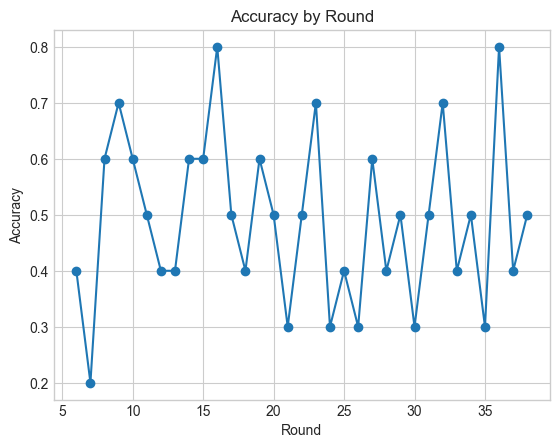

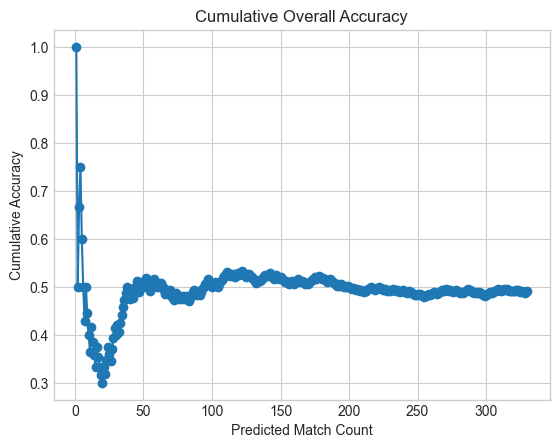

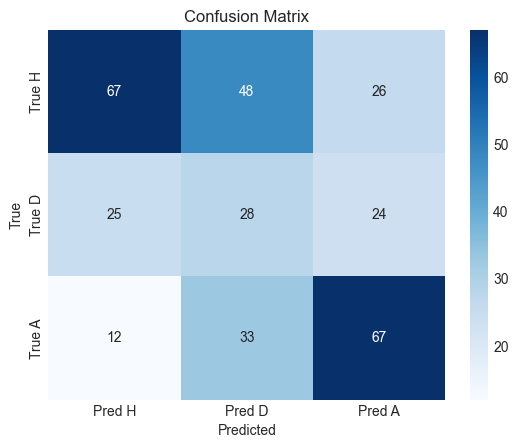

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# 7.0 Overall accuracy (text)
df_res = results_df[['Round','Actual','Predicted']].copy() if 'results_df' in globals() else pd.DataFrame(columns=['Round','Actual','Predicted'])
overall_acc = (df_res['Actual'] == df_res['Predicted']).mean() if len(df_res) else float('nan')
print(f"Overall accuracy = {overall_acc:.3f}")

# 7.1 Accuracy by Round (line plot)
if len(df_res):
    res2 = df_res.assign(correct=(df_res['Actual'] == df_res['Predicted']))
    round_acc = (res2.groupby('Round', as_index=False)['correct']
                    .mean()
                    .rename(columns={'correct':'Accuracy'}))
    plt.figure()
    plt.plot(round_acc['Round'], round_acc['Accuracy'], marker='o')
    plt.title('Accuracy by Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

# 7.2 Cumulative Overall Accuracy (line plot)
if len(df_res):
    df_sorted = df_res.sort_values('Round').reset_index(drop=True)
    hits = (df_sorted['Actual'] == df_sorted['Predicted']).astype(int)
    cum_acc = hits.cumsum() / np.arange(1, len(hits)+1)
    plt.figure()
    plt.plot(range(1, len(cum_acc)+1), cum_acc, marker='o')
    plt.title('Cumulative Overall Accuracy')
    plt.xlabel('Predicted Match Count')
    plt.ylabel('Cumulative Accuracy')
    plt.grid(True)
    plt.show()

# 7.2.a Confusion matrix (heatmap)
if len(df_res):
    uniq = pd.unique(pd.concat([df_res['Actual'], df_res['Predicted']], ignore_index=True))
    if set(map(str, uniq)) <= set(['H','D','A']):
        labels = ['H','D','A']
        xt = ['Pred H','Pred D','Pred A']; yt = ['True H','True D','True A']
    else:
        labels = [1, 0, -1]
        xt = ['Pred H','Pred D','Pred A']; yt = ['True H','True D','True A']

    cm = confusion_matrix(df_res['Actual'], df_res['Predicted'], labels=labels)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=xt, yticklabels=yt)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


8. Gradio Interface

In [8]:
import os, cloudpickle
import numpy as np
import pandas as pd
import gradio as gr

# 8.0 Load trained pipeline
if 'best_pipeline' not in globals():
    if os.path.exists("svr_final_pipeline.pkl"):
        with open("svr_final_pipeline.pkl", "rb") as f:
            best_pipeline = cloudpickle.load(f)
    elif 'final_model' in globals():
        best_pipeline = final_model
    else:
        raise RuntimeError("Trained pipeline not found. Run Sections 5–6 first.")

# 8.0.b Ensure df exists for UI
if 'df' not in globals():
    if os.path.exists('df_processed.parquet'):
        df = pd.read_parquet('df_processed.parquet')
    elif os.path.exists('df_processed.csv'):
        df = pd.read_csv('df_processed.csv')
    else:
        raise RuntimeError("Dataframe 'df' not found. Run Sections 2–3 first or save the processed dataframe.")

# 8.1 Precompute odds means
odd_feats = ['ImpProb_H','ImpProb_D','ImpProb_A','ImpOver2.5','ImpUnder2.5','OddsSpread']
odd_means = df[odd_feats].mean(numeric_only=True) if set(odd_feats).issubset(df.columns) else pd.Series(dtype=float)

# 8.2 Dropdown choices
teams = sorted(pd.unique(pd.concat([df['HomeTeam'].astype(str), df['AwayTeam'].astype(str)])))
refs  = sorted(df['Referee'].astype(str).unique())
times = ['Morning','Afternoon','Evening']

# 8.3 Rolling stats lists
home_stats = home_stats if 'home_stats' in globals() else ['HS','HST','HF','HC','HY','HR']
away_stats = away_stats if 'away_stats' in globals() else ['AS','AST','AF','AC','AY','AR']

# 8.4 Prediction function
def predict_outcome(home_team, away_team, referee, time_of_day):
    data = {}
    data['HomeTeam']  = str(home_team)
    data['AwayTeam']  = str(away_team)
    data['Referee']   = str(referee)
    data['TimeOfDay'] = str(time_of_day)

    # latest context rows
    hrows = df[df['HomeTeam'] == home_team]
    arows = df[df['AwayTeam'] == away_team]
    rrows = df[df['Referee']  == referee]
    hrow  = hrows.iloc[-1] if len(hrows) else pd.Series(dtype=object)
    arow  = arows.iloc[-1] if len(arows) else pd.Series(dtype=object)
    rrow  = rrows.iloc[-1] if len(rrows) else pd.Series(dtype=object)

    # odds features (use global means in UI)
    for s in odd_feats:
        if s in df.columns:
            data[s] = float(odd_means.get(s, np.nan))

    # home numerics
    for s in ['HomeForm3','HomeStreak','HomePosPrev'] + [f'Home_{s}_3' for s in home_stats]:
        if s in df.columns and s in hrow.index:
            data[s] = hrow[s]

    # away numerics
    for s in ['AwayForm3','AwayStreak','AwayPosPrev'] + [f'Away_{s}_3' for s in away_stats]:
        if s in df.columns and s in arow.index:
            data[s] = arow[s]

    # referee bias
    if 'RefBias' in df.columns and 'RefBias' in rrow.index:
        data['RefBias'] = rrow['RefBias']
    elif 'RefBias' in df.columns:
        data['RefBias'] = 0.5

    # recent head-to-head
    if 'H2H_Last' in df.columns:
        pair = tuple(sorted([home_team, away_team]))
        pairs = df.apply(lambda r: tuple(sorted([r['HomeTeam'], r['AwayTeam']])), axis=1)
        hits = df.loc[pairs[pairs == pair].index]
        data['H2H_Last'] = hits['H2H_Last'].iloc[-1] if len(hits) else 0.0

    # engineered
    if ('Spread×Form' in df.columns):
        hf  = data.get('HomeForm3', np.nan)
        spr = data.get('OddsSpread', np.nan)
        data['Spread×Form'] = (hf * spr) if (pd.notna(hf) and pd.notna(spr)) else np.nan
    if ('FormDiff' in df.columns):
        hf = data.get('HomeForm3', np.nan)
        af = data.get('AwayForm3', np.nan)
        data['FormDiff'] = (hf - af) if (pd.notna(hf) and pd.notna(af)) else np.nan

    X = pd.DataFrame([data])

    # ensure expected features present & aligned
    expected = []
    if 'cat_feats' in globals(): expected += list(cat_feats)
    if 'num_feats' in globals(): expected += list(num_feats)
    if not expected:
        try:
            pre = best_pipeline.named_steps.get('pre')
            expected = list(pre.transformers_[0][2]) + list(pre.transformers_[1][2])
        except Exception:
            expected = list(X.columns)

    if 'FormDiff' in expected and 'FormDiff' not in X.columns:
        if {'HomeForm3','AwayForm3'}.issubset(X.columns):
            X['FormDiff'] = X['HomeForm3'] - X['AwayForm3']
        else:
            X['FormDiff'] = np.nan

    for c in expected:
        if c not in X.columns:
            X[c] = np.nan
    X = X.reindex(columns=expected, fill_value=np.nan)

    # probabilities → H/D/A
    probs = best_pipeline.predict_proba(X)[0]
    classes = list(best_pipeline.classes_)

    def get_prob(cls_num, cls_chr):
        if cls_num in classes: return probs[classes.index(cls_num)]
        if cls_chr in classes: return probs[classes.index(cls_chr)]
        return 0.0

    pH = get_prob(1, 'H'); pD = get_prob(0, 'D'); pA = get_prob(-1, 'A')
    p = np.array([pH, pD, pA], dtype=float)
    p = np.clip(p, 0, None); s = p.sum()
    p = (np.ones(3)/3) if (not np.isfinite(s) or s<=0) else (p/s)

    H_pct = float(np.round(p[0]*100, 2))
    D_pct = float(np.round(p[1]*100, 2))
    A_pct = float(np.round(100.0 - H_pct - D_pct, 2))
    return H_pct, D_pct, A_pct

# 8.5 Gradio UI
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(choices=teams, label="Home Team"),
        gr.Dropdown(choices=teams, label="Away Team"),
        gr.Dropdown(choices=refs,  label="Referee"),
        gr.Radio(choices=times,    label="Time of Day", value='Afternoon'),
    ],
    outputs=[
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %"),
    ],
    title="Premier League Outcome Predictor (SVC)",
    description="Round-by-round football match outcome predictor with SVC and automated warm-up HPO."
)

# iface.launch()  # uncomment to run
